In [1]:
import psycopg2
import pandas as pd
from sqlalchemy import create_engine
from causalgraphicalmodels import CausalGraphicalModel
from dowhy import CausalModel
import dowhy.datasets
from networkx.drawing.nx_pydot import write_dot
import networkx as nx
import matplotlib.pyplot as plt
from networkx.readwrite.gml import write_gml
import numpy as np

In [2]:
def gen_estimate(gml_graph, input_df, treatment_col, outcome_col):
        # With graph
    model=CausalModel(
            data = input_df,
            treatment=treatment_col,
            outcome=outcome_col,
            graph=gml_graph
            )
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    causal_estimate = model.estimate_effect(identified_estimand,
            method_name="backdoor.linear_regression",target_units="ate")
    print(causal_estimate)
    return causal_estimate.value

In [36]:
def filter_skewed(treatment_cols, seasons, df):
    values = []
    for t in treatment_cols:
        print(t)
        tmp = []
        for s in seasons:
            print(s)
            one_season = df[df['season'] == s]
            treated = len(one_season[one_season[t] == 1])
            untreated = len(one_season[one_season[t] == 0])
            th = treated/(treated + untreated)
            if (th < 0.3):
                tmp.append(None)
            else:
                tmp.append(th)
        print(tmp)
        values.append(tmp)
    return dict(zip(treatment_cols, values))

In [4]:
def get_df(treatment, df):
    df_return = df
    min_ = round(df_return[treatment].min(), 3)
    max_ = round(df_return[treatment].max(), 3)
    interval = [min_, max_]
    p_25 = round(np.percentile(interval, 25), 3)
    p_50 = round(np.percentile(interval, 50), 3)
    p_75 = round(np.percentile(interval, 75), 3)
    column = [min_, p_25, p_50, p_75, max_]
    column_name = [treatment+str(min_)+'_'+str(p_25), treatment+str(p_25)+'_'+str(p_50), 
                   treatment+str(p_50)+'_'+str(p_75), treatment+str(p_75)+'_'+str(max_)]
    
    for i in range(len(column_name)):
        df_return[column_name[i]] = 0
        slice_indices = (df_return[treatment] > column[i] - 0.001) & (df[treatment] <= column[i+1])
        df_return.loc[slice_indices, column_name[i]]=1
    
    return df_return, column_name

In [5]:
def graph(treatment, treatmemt_i, outcome):
    lst = [
            ("Minutes", "Assists"), 
            ("Minutes", "Rebounds"), 
            ("Minutes", "Points"), 
            ("Fg3Pct", "Points"),
            ("Fg2Pct", "Points"), 
            ("Points", outcome),
            ("Assists", outcome),
            ("Rebounds", outcome),
            ("Turnovers", outcome),
            ("Fouls", outcome),
            ("is_home", outcome),
    ]
    
    for i in range(len(lst)):
        lst[i] = list(lst[i])
        if lst[i][0] == treatment:
            lst[i][0] = treatmemt_i
        if lst[i][1] == treatment:
            lst[i][1] = treatmemt_i
        lst[i] = tuple(lst[i])

    G = nx.DiGraph()
    G.add_edges_from(lst)
    write_gml(G, 'testgml')
    with open('testgml') as f: s = f.read()
    return s

In [37]:
def get_est(player_name, treatment, outcome, season_type):
    loc = '/Users/sdy/Desktop/Casual Inference/' + str(player_name) + '.csv'
    df = pd.read_csv(loc)
    df = df.fillna(0)
    df = df.drop(['Unnamed: 0'],axis=1)
    df = df.drop(["Date","HomePoints",
                         "AwayPoints", "HomeTeamAbbreviation","AwayTeamAbbreviation", 
                         "FtPoints", "FG2A", "FG3A"],axis=1)
    
    seasons = df['season'].unique()
    
    if season_type == 'Regular Season':
        df_regular = df[df['season_type'] == 'Regular Season']
        df, treatment_cols = get_df(treatment, df_regular)
        th = filter_skewed(treatment_cols, seasons, df)
        df = df.groupby('season')
    
    if season_type == 'Playoffs':
        df_playoff = df[df['season_type'] == 'Playoffs']
        df, treatment_cols = get_df(treatment, df_playoff)
        th = filter_skewed(treatment_cols, seasons, df)
        df = df.groupby('season')


    estimates  = []
    
    for t in treatment_cols:
        th_i = th.get(t)
        i = 0
        for season, split_df in df:
            if th_i[i] == None:
                estimates.append({'treatment':t, 'outcome':outcome, 'season':season,'ate':None})
            else:
                try:
                    est = gen_estimate(graph(treatment, t, outcome),split_df,t,outcome)
                    estimates.append({'treatment':t, 'outcome':outcome, 'season':season,'ate':est})
                except:
                    estimates.append({'treatment':t, 'season':season, 'estimate':None})
            i = i+1
    estimates_df=pd.DataFrame(estimates)
    
    return estimates_df 

# Causal Graph

In [42]:
loc = '/Users/sdy/Desktop/Casual Inference/herro.csv'
df = pd.read_csv(loc)
df = df.fillna(0)
df = df.drop(['Unnamed: 0'],axis=1)
df = df.drop(["Date","HomePoints",
                     "AwayPoints", "HomeTeamAbbreviation","AwayTeamAbbreviation", 
                     "FtPoints", "FG2A", "FG3A"],axis=1)

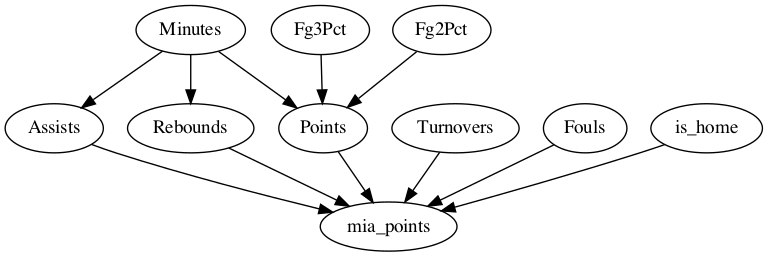

In [43]:
lst = [
        ("Minutes", "Assists"), 
        ("Minutes", "Rebounds"), 
        ("Minutes", "Points"), 
        ("Fg3Pct", "Points"),
        ("Fg2Pct", "Points"), 
        ("Points", outcome),
        ("Assists", outcome),
        ("Rebounds", outcome),
        ("Turnovers", outcome),
        ("Fouls", outcome),
        ("is_home", outcome),
]


G = nx.DiGraph()
G.add_edges_from(lst)
write_gml(G, 'testgml')
with open('testgml') as f: s = f.read()
    
import pygraphviz

model= dowhy.CausalModel(
        data = df,
        graph=s,
        treatment= 'Minutes',
        outcome= 'mia_points')
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

# Herro

In [51]:
estimate_df_minutes_mia_points = get_est('herro', 'Minutes', 'mia_points', 'Regular Season')

estimate_df_assists_mia_points = get_est('herro', 'Assists', 'mia_points', 'Regular Season')

estimate_df_rebounds_mia_points = get_est('herro', 'Rebounds', 'mia_points', 'Regular Season')

estimate_df_points_mia_points = get_est('herro', 'Points', 'mia_points', 'Regular Season')

estimate_df_turnovers_mia_points = get_est('herro', 'Turnovers', 'mia_points', 'Regular Season')

estimate_df_fouls_mia_points = get_est('herro', 'Fouls', 'mia_points', 'Regular Season')

estimate_df_fg3_mia_points = get_est('herro', 'Fg3Pct', 'mia_points', 'Regular Season')

estimate_df_fg2_mia_points = get_est('herro', 'Fg2Pct', 'mia_points', 'Regular Season')

/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_69063/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_69063/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_69063/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

Minutes7.3_16.658
2019-20
2020-21
2021-22
[None, None, None]
Minutes16.658_26.016
2019-20
2020-21
2021-22
[0.36363636363636365, None, None]
Minutes26.016_35.375
2019-20
2020-21
2021-22
[0.41818181818181815, 0.6481481481481481, 0.7121212121212122]
Minutes35.375_44.733
2019-20
2020-21
2021-22
[None, None, None]
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                         
───────────────────────(E[miaₚₒᵢₙₜₛ])
d[Minutes16.658_26.016]              
Estimand assumption 1, Unconfoundedness: If U→{Minutes16.658_26.016} and U→mia_points then P(mia_points|Minutes16.658_26.016,,U) = P(mia_points|Minutes16.658_26.016,)

## Realized estimand
b: mia_points~Minutes16.658_26.016+Minutes16.658_26.016*Turnovers+Minutes16.658_26.016*is_home+Minutes16.658_26.016*Fouls+Minutes16.658_26.016*Fg3Pct+Minutes16.658_26.016*Fg2Pct
Target units: ate

## Estimate
Mean value: -0.89284

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                
───────────────────(E[mia_points|Minutes])
d[Rebounds3.75_7.5]                       
Estimand assumption 1, Unconfoundedness: If U→{Rebounds3.75_7.5} and U→mia_points then P(mia_points|Rebounds3.75_7.5,Minutes,U) = P(mia_points|Rebounds3.75_7.5,Minutes)

## Realized estimand
b: mia_points~Rebounds3.75_7.5+Minutes+Rebounds3.75_7.5*Turnovers+Rebounds3.75_7.5*is_home+Rebounds3.75_7.5*Fouls+Rebounds3.75_7.5*Assists+Rebounds3.75_7.5*Fg3Pct+Rebounds3.75_7.5*Points+Rebounds3.75_7.5*Fg2Pct
Target units: ate

## Estimate
Mean value: -1.01093856527838

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                
───────────────────(E[mia_points|Minutes])
d[Rebou

/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_69063/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_69063/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_69063/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                      
────────────────(E[miaₚₒᵢₙₜₛ])
d[Fouls0.0_1.25]              
Estimand assumption 1, Unconfoundedness: If U→{Fouls0.0_1.25} and U→mia_points then P(mia_points|Fouls0.0_1.25,,U) = P(mia_points|Fouls0.0_1.25,)

## Realized estimand
b: mia_points~Fouls0.0_1.25+Fouls0.0_1.25*Fg2Pct+Fouls0.0_1.25*Turnovers+Fouls0.0_1.25*Rebounds+Fouls0.0_1.25*is_home+Fouls0.0_1.25*Assists+Fouls0.0_1.25*Fg3Pct+Fouls0.0_1.25*Points+Fouls0.0_1.25*Minutes
Target units: ate

## Estimate
Mean value: -5.356986387824378

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                      
────────────────(E[miaₚₒᵢₙₜₛ])
d[Fouls0.0_1.25]              
Estimand assumption 1, Unconfoundedness: If U→{Fouls0.0_1.25} and

/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_69063/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_69063/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return[column_name[i]] = 0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_69063/1618561880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [52]:
estimate_df_minutes_mia_points

,treatment,outcome,season,ate
0,Minutes7.3_16.658,mia_points,2019-20,NaN
1,Minutes7.3_16.658,mia_points,2020-21,NaN
2,Minutes7.3_16.658,mia_points,2021-22,NaN
3,Minutes16.658_26.016,mia_points,2019-20,-0.892845
4,Minutes16.658_26.016,mia_points,2020-21,NaN
5,Minutes16.658_26.016,mia_points,2021-22,NaN
6,Minutes26.016_35.375,mia_points,2019-20,3.006094
7,Minutes26.016_35.375,mia_points,2020-21,-4.267399
8,Minutes26.016_35.375,mia_points,2021-22,-0.532814
9,Minutes35.375_44.733,mia_points,2019-20,NaN


In [53]:
estimate_df_assists_mia_points

,treatment,outcome,season,ate
0,Assists0.0_2.75,mia_points,2019-20,2.414252
1,Assists0.0_2.75,mia_points,2020-21,-1.034040
2,Assists0.0_2.75,mia_points,2021-22,NaN
3,Assists2.75_5.5,mia_points,2019-20,NaN
4,Assists2.75_5.5,mia_points,2020-21,2.021127
5,Assists2.75_5.5,mia_points,2021-22,5.825654
6,Assists5.5_8.25,mia_points,2019-20,NaN
7,Assists5.5_8.25,mia_points,2020-21,NaN
8,Assists5.5_8.25,mia_points,2021-22,NaN
9,Assists8.25_11.0,mia_points,2019-20,NaN


In [54]:
estimate_df_rebounds_mia_points

,treatment,outcome,season,ate
0,Rebounds0.0_3.75,mia_points,2019-20,-0.691531
1,Rebounds0.0_3.75,mia_points,2020-21,-5.039449
2,Rebounds0.0_3.75,mia_points,2021-22,NaN
3,Rebounds3.75_7.5,mia_points,2019-20,1.180592
4,Rebounds3.75_7.5,mia_points,2020-21,-1.010939
5,Rebounds3.75_7.5,mia_points,2021-22,4.451819
6,Rebounds7.5_11.25,mia_points,2019-20,NaN
7,Rebounds7.5_11.25,mia_points,2020-21,NaN
8,Rebounds7.5_11.25,mia_points,2021-22,NaN
9,Rebounds11.25_15.0,mia_points,2019-20,NaN


In [55]:
estimate_df_points_mia_points

,treatment,outcome,season,ate
0,Points0.0_8.75,mia_points,2019-20,NaN
1,Points0.0_8.75,mia_points,2020-21,NaN
2,Points0.0_8.75,mia_points,2021-22,NaN
3,Points8.75_17.5,mia_points,2019-20,2.036286
4,Points8.75_17.5,mia_points,2020-21,-4.621173
5,Points8.75_17.5,mia_points,2021-22,-5.065490
6,Points17.5_26.25,mia_points,2019-20,NaN
7,Points17.5_26.25,mia_points,2020-21,NaN
8,Points17.5_26.25,mia_points,2021-22,1.455890
9,Points26.25_35.0,mia_points,2019-20,NaN


In [56]:
estimate_df_turnovers_mia_points

,treatment,outcome,season,ate
0,Turnovers0.0_2.0,mia_points,2019-20,2.132718
1,Turnovers0.0_2.0,mia_points,2020-21,-5.347903
2,Turnovers0.0_2.0,mia_points,2021-22,0.630321
3,Turnovers2.0_4.0,mia_points,2019-20,-4.127585
4,Turnovers2.0_4.0,mia_points,2020-21,2.644993
5,Turnovers2.0_4.0,mia_points,2021-22,1.841357
6,Turnovers4.0_6.0,mia_points,2019-20,NaN
7,Turnovers4.0_6.0,mia_points,2020-21,NaN
8,Turnovers4.0_6.0,mia_points,2021-22,NaN
9,Turnovers6.0_8.0,mia_points,2019-20,NaN


In [57]:
estimate_df_fouls_mia_points

,treatment,outcome,season,ate
0,Fouls0.0_1.25,mia_points,2019-20,-1.620975
1,Fouls0.0_1.25,mia_points,2020-21,-5.356986
2,Fouls0.0_1.25,mia_points,2021-22,-2.821334
3,Fouls1.25_2.5,mia_points,2019-20,NaN
4,Fouls1.25_2.5,mia_points,2020-21,NaN
5,Fouls1.25_2.5,mia_points,2021-22,NaN
6,Fouls2.5_3.75,mia_points,2019-20,NaN
7,Fouls2.5_3.75,mia_points,2020-21,NaN
8,Fouls2.5_3.75,mia_points,2021-22,NaN
9,Fouls3.75_5.0,mia_points,2019-20,NaN


In [58]:
estimate_df_fg3_mia_points

,treatment,outcome,season,ate
0,Fg3Pct0.0_0.214,mia_points,2019-20,NaN
1,Fg3Pct0.0_0.214,mia_points,2020-21,0.246591
2,Fg3Pct0.0_0.214,mia_points,2021-22,NaN
3,Fg3Pct0.214_0.428,mia_points,2019-20,-0.435791
4,Fg3Pct0.214_0.428,mia_points,2020-21,NaN
5,Fg3Pct0.214_0.428,mia_points,2021-22,-9.430844
6,Fg3Pct0.428_0.643,mia_points,2019-20,NaN
7,Fg3Pct0.428_0.643,mia_points,2020-21,NaN
8,Fg3Pct0.428_0.643,mia_points,2021-22,6.327129
9,Fg3Pct0.643_0.857,mia_points,2019-20,NaN


In [59]:
estimate_df_fg2_mia_points

,treatment,outcome,season,ate
0,Fg2Pct0.0_0.25,mia_points,2019-20,NaN
1,Fg2Pct0.0_0.25,mia_points,2020-21,NaN
2,Fg2Pct0.0_0.25,mia_points,2021-22,NaN
3,Fg2Pct0.25_0.5,mia_points,2019-20,-7.879795
4,Fg2Pct0.25_0.5,mia_points,2020-21,-4.021018
5,Fg2Pct0.25_0.5,mia_points,2021-22,-3.896983
6,Fg2Pct0.5_0.75,mia_points,2019-20,-2.066223
7,Fg2Pct0.5_0.75,mia_points,2020-21,2.282158
8,Fg2Pct0.5_0.75,mia_points,2021-22,3.892101
9,Fg2Pct0.75_1.0,mia_points,2019-20,NaN


# Jimmy Butler

# Curry

# Thompson